In [1]:
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy.signal import butter, lfilter, iirnotch
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
import matplotlib.pyplot as plt

In [2]:
def butter_filter(data, cutoff, fs, btype='low', order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = lfilter(b, a, data, axis=0)
    return y

def notch_filter(signal, fs, freq=50, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return lfilter(b, a, signal, axis=0)

In [3]:
debug = False

# Setting up the board
if debug:
    # Create a synthetic board for debugging purposes
    board_id = BoardIds.SYNTHETIC_BOARD
    params = BrainFlowInputParams()
else:
    # Setting up the board
    params = BrainFlowInputParams()
    params.serial_number = 'UN-2023.02.30'
    board_id = BoardIds.UNICORN_BOARD
    
board = BoardShim(board_id, params)

# Getting specific board details
channels = board.get_eeg_channels(board_id) #EEG Channels
timestamp_channel = board.get_timestamp_channel(board_id) # Timestamp channel
marker_channel = board.get_marker_channel(board_id) # Marker channel for synchronization
sampling_rate = BoardShim.get_sampling_rate(board_id) # Hz

In [4]:
dataset = np.loadtxt(r"..//eeg_data.csv", delimiter=",")

In [5]:
eegdata = dataset[:, channels]
markers = dataset[:, marker_channel]

In [6]:
# Getting markers
idx_starting_markers = np.arange(0, len(markers))
idx_starting_markers = idx_starting_markers[markers != 0]
idx_starting_markers = idx_starting_markers[markers[idx_starting_markers] != 67]

idx_end_markers = np.arange(0, len(markers))[markers == 67]

# Preprocessing EEG
start = idx_end_markers[0]
idx_end_markers = idx_end_markers[1:]

raw_label = np.zeros_like(markers)

# Set label outputs to constant
for i in range(len(idx_starting_markers)):
    marker = markers[idx_starting_markers[i]]
    raw_label[idx_starting_markers[i]:idx_end_markers[i]] = marker

good_eeg = eegdata[start:, :]
good_label = raw_label[start:]

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import copy

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
num_classes = 4

val_idx = int(0.8*len(good_label))
test_idx = int(0.9*len(good_label))

X = {}
y = {}

X["Train"] = good_eeg[:val_idx]
y["Train"] = good_label[:val_idx]

X["Val"] = good_eeg[val_idx:test_idx]
y["Val"] = good_label[val_idx:test_idx]

X["Test"] = good_eeg[test_idx:]
y["Test"] = good_label[test_idx:]

In [10]:
classes, counts = np.unique(y["Train"], return_counts=True)
weights = 1.0 / counts   # inverse frequency
weights = weights / weights.sum()  # normalize (optional)

class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print(class_weights)  # e.g., tensor([0.25, 0.1667, 0.5])

tensor([0.1604, 0.4182, 0.4214], device='cuda:0')


In [11]:
step = 20
window_size = int(4*sampling_rate)
buffer = 750

class EEGDataset(Dataset):
    def __init__(self, data_type):
        self.data_type = data_type
    
    def __len__(self):
        return ( len(y[self.data_type]) - window_size - buffer ) // step
    
    def __getitem__(self, idx):
        i = int(idx*step)

        temp_emg = good_eeg[ i:i+window_size+buffer, : ]

        # Preprocess EMG
        temp_emg = butter_filter(temp_emg, 3, sampling_rate, btype='high', order=2)
        temp_emg = butter_filter(temp_emg, 80, sampling_rate, btype='low', order=2)
        temp_emg = notch_filter(temp_emg, sampling_rate, freq=60)

        temp_emg = temp_emg[buffer:, :]
        temp_emg -= np.mean(temp_emg, axis=1, keepdims=True)

        temp_mean = np.mean(temp_emg, axis=0, keepdims=True)
        temp_std = np.std(temp_emg, axis=0, keepdims=True)

        temp_emg = (temp_emg - temp_mean) / temp_std

        # Preprocess
        temp_label = good_label[i+window_size+buffer-125]

        # Get the EEG data and corresponding label
        eeg = torch.tensor(temp_emg, dtype=torch.float32)
        label = torch.tensor(temp_label, dtype=torch.long)

        return eeg, label
    
train_dataset = EEGDataset("Train")
val_dataset = EEGDataset("Val")
test_dataset = EEGDataset("Test")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
train_dataset[0][0].shape

torch.Size([1000, 8])

In [13]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs, hidden):

        seq_len = encoder_outputs.size(1)
        h_tiled = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((encoder_outputs, h_tiled), dim=2)))
        attn_weights = torch.softmax(self.v(energy), dim=1)
        context_vector = torch.sum(attn_weights * encoder_outputs, dim=1)

        return context_vector

class DPARSEncoder(nn.Module):
    def __init__(self, input_size, encode_size, num_classes):
        super(DPARSEncoder, self).__init__()
        second_size = input_size*2
        
        self.bn1 = nn.BatchNorm1d(second_size)
        self.bn2 = nn.BatchNorm1d(encode_size)
        self.dropout = nn.Dropout(p=0.3)
        self.attention = Attention(2*encode_size)

        self.depthwise1 = nn.Conv1d(
            input_size, input_size, kernel_size=64, stride = 16, groups=input_size, bias=False)
        self.pointwise1 = nn.Conv1d(input_size, second_size, kernel_size=1)


        self.depthwise2 = nn.Conv1d(
            second_size, second_size, kernel_size=16, stride = 4, groups=second_size, bias=False)
        self.pointwise2 = nn.Conv1d(second_size, encode_size, kernel_size=1)

        self.fc1 = nn.Linear(encode_size, num_classes)
        self.relu = nn.ReLU()


    def forward(self, x):

        # Input -> (batch_size, 1000, 8)
        x = x.permute(0, 2, 1)
        x = self.depthwise1(x)  # output: (batch, 64, 48)
        x = self.pointwise1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        # print(x.shape)


        x = self.depthwise2(x)  # output: (batch, 64, 48)
        x = self.pointwise2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = x.permute(0, 2, 1)
        x = self.attention(x, x[:, -1, :])
        # print(x.shape)

        return self.fc1(x)

In [14]:
model = DPARSEncoder(8, 16, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # optimize all parameters
criterion = nn.CrossEntropyLoss(weight=class_weights)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(75):
    
    # Train the data
    model.train()
    running_loss = 0.0
    for inputs, label in train_loader:
        # Inputs are in shape (batch_size, channels, timepoints)
        # Need to transform to (batch_size, 1, channels, timepoints)
        inputs = inputs.to(device)
        label = label.to(device)
        
        model_output = model(inputs)
        loss = criterion(model_output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validate Data
    model.eval()
    val_acc = 0
    with torch.no_grad():
        for inputs, label in val_loader:
            # Inputs are in shape (batch_size, channels, timepoints)
            # Need to transform to (batch_size, 1, channels, timepoints)
            inputs = inputs.to(device)
            label = label.to(device)
            
            model_output = model(inputs)
            pred = model_output.argmax(dim=1, keepdim=True)
            val_acc += pred.eq(label.view_as(pred)).sum().item()

    # Print to see status
    print(f'Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader):.3f}, Validation Acc: {val_acc/len(val_loader.dataset):.3f}%')

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

Epoch 1, Training Loss: 1.122, Validation Acc: 0.351%
Epoch 2, Training Loss: 1.086, Validation Acc: 0.395%
Epoch 3, Training Loss: 1.064, Validation Acc: 0.385%
Epoch 4, Training Loss: 1.026, Validation Acc: 0.559%
Epoch 5, Training Loss: 0.982, Validation Acc: 0.607%
Epoch 6, Training Loss: 0.942, Validation Acc: 0.674%
Epoch 7, Training Loss: 0.899, Validation Acc: 0.703%
Epoch 8, Training Loss: 0.863, Validation Acc: 0.692%
Epoch 9, Training Loss: 0.846, Validation Acc: 0.726%
Epoch 10, Training Loss: 0.818, Validation Acc: 0.740%
Epoch 11, Training Loss: 0.777, Validation Acc: 0.763%
Epoch 12, Training Loss: 0.761, Validation Acc: 0.730%
Epoch 13, Training Loss: 0.737, Validation Acc: 0.788%
Epoch 14, Training Loss: 0.719, Validation Acc: 0.736%
Epoch 15, Training Loss: 0.713, Validation Acc: 0.757%
Epoch 16, Training Loss: 0.683, Validation Acc: 0.790%
Epoch 17, Training Loss: 0.669, Validation Acc: 0.796%
Epoch 18, Training Loss: 0.650, Validation Acc: 0.782%
Epoch 19, Training 

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Example usage:
# model = SomeModel()  # Replace with your actual model
encoder_count = count_parameters(model)
# rnn = count_parameters(rnn_DPARS)
print(f'The model has {encoder_count} parameters.')

The model has 2387 parameters.


(64,)
(128,)
(192,)
(256,)
(320,)
(384,)
(448,)
accuracy = 90.45643153526972
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


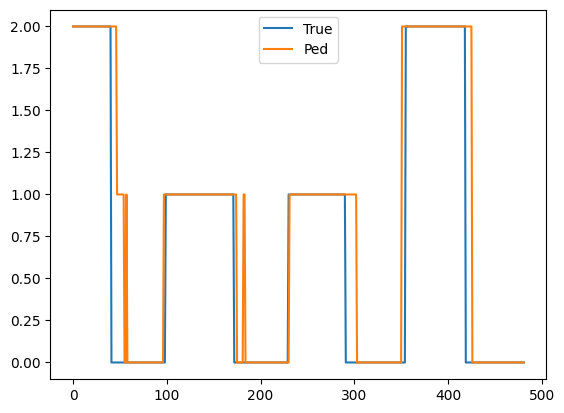

In [17]:
model.load_state_dict(best_model_wts)
# test
pred_list = []
true_list = []
flag = 0

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for eeg, labels in test_loader:
        eeg = eeg.to(device)
        labels = labels.to(device)
        outputs = model(eeg)
        
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions==labels).sum().item()

        if flag == 0:
            pred_list = predictions.cpu().detach().numpy()
            true_list = labels.cpu().detach().numpy()
            flag = 1
        else:
            pred = predictions.cpu().detach().numpy()
            true = labels.cpu().detach().numpy()

            print(pred_list.shape)
            pred_list = np.concatenate((pred_list, pred))
            true_list = np.concatenate((true_list, true))
        
    acc = 100 * (n_correct/n_samples)
    print(f'accuracy = {acc}')

    print(predictions)
    print(labels)


plt.plot(true_list, label="True")
plt.plot(pred_list, label="Ped")
plt.legend()

In [ ]:
step = 20
window_size = int(4*sampling_rate)
buffer = 750

pred_label = []
true_label = []


model.eval()
with torch.no_grad():
    i=0
    while i <  len(good_eeg) - window_size - buffer:
        temp_eeg = good_eeg[ i:i+window_size+buffer, : ]

        # Preprocess EMG
        temp_eeg = butter_filter(temp_eeg, 3, sampling_rate, btype='high', order=2)
        temp_eeg = butter_filter(temp_eeg, 80, sampling_rate, btype='low', order=2)
        temp_eeg = notch_filter(temp_eeg, sampling_rate, freq=60)
        temp_eeg = temp_eeg[buffer:, :]
        temp_eeg -= np.mean(temp_eeg, axis=1, keepdims=True)
        temp_mean = np.mean(temp_eeg, axis=0, keepdims=True)
        temp_std = np.std(temp_eeg, axis=0, keepdims=True)
        temp_eeg = (temp_eeg - temp_mean) / temp_std

        # Preprocess
        temp_label = good_label[i+window_size+buffer-125]
        true_label.append(temp_label)

        temp_eeg = torch.tensor(temp_eeg, dtype=torch.float32).unsqueeze(0).to(device)
        outputs = model(temp_eeg)
        
        predictions = outputs.argmax(dim=1, keepdim=True)
        pred = predictions.cpu().detach().numpy()[0][0]

        pred_label.append(pred)
        i += step


In [ ]:
pred_label = np.array(pred_label)
true_label = np.array(true_label)
plt.plot(pred_label, label='Predicted Label')
plt.plot(true_label, label='True Label')
plt.legend()
plt.show()

In [ ]:
np.sum(true_label == pred_label) / len(true_label)

In [15]:
torch.save(model.state_dict(), f"model.pth")